In [199]:
import numpy as np
#import cv2
import os
#from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
from glob import glob
from skimage import io, transform


def rgb2grey(image):
    gray = image[:, :, 0] * 0.299 + image[:, :, 1] * 0.587 + image[:, :, 2] * 0.114 + 0.5
    #gray = np.sum(image, axis=2) / 3.0
    gray = gray.astype(np.uint8)
    return gray

def rgb2bw(image, threshold):
    gray = rgb2grey(image)
    idx1 = gray <= threshold
    idx2 = gray >= threshold
    gray[idx1] = 255
    gray[idx2] = 0
    return gray;


# 读取目录下所有的jpg图片
def load_image(image_path, image_height, image_width):
    file_name=glob(image_path+"/*jpg")
    sample = []
    for file in file_name:
        #pic = imread(file).astype(np.float32)
        #pic = imresize(pic, (image_size, image_size)).astype(np.float32)
        pic = io.imread(file)#.astype(np.float32)         
        print(pic.shape, np.min(pic), np.max(pic))
        pic = transform.resize(pic, (image_height, image_width)) * 255
        pic = pic.astype(np.uint8)
        #print(pic.shape, np.min(pic), np.max(pic))
        sample.append(pic)
 
    sample = np.array(sample)
    return sample



def preprocess(image):
    image = image[:, 4:28]
    return image

(962, 1186, 3) 0 255
(1032, 1156, 3) 0 255
(988, 1178, 3) 0 255
(994, 1176, 3) 0 255


/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(4, 24, 32, 3)


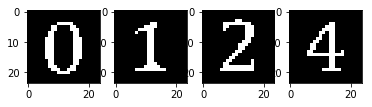

In [200]:
# original image size 
# nh = 962, nw = 1156

# original image size 
# nh = 480, nw = 640

nh = 24
nw = 32
gc = 127

master = []


samples = load_image("./data", nh, nw)
print(samples.shape)

for i in range(len(samples)):
    plt.subplot(1, 4, i + 1)

    pic = samples[i, :, :, :]
    #plt.imshow(pic)

    dat = rgb2bw(pic, gc)
    dat = preprocess(dat)
    plt.imshow(dat, cmap='gray')
    
    master.append(dat)
    
plt.show()
master = np.array(master)

In [201]:
def denoise(image, nh, nw):
    ne = int(nw / 6.0)
    image[:, :ne] = 255
    image[:, nw-ne:] = 255
    return image

def similarity(a, b):
    return np.sum(a*b)/(np.sqrt(np.sum(a*a)) * np.sqrt(np.sum(b*b)))

def match(master, pic):
    flag = -1
    sim = -1.0          
    print(master.shape)
    for k in range(len(master)):
        mas = master[k,:,:]
        coe = similarity(mas, pic)
        #print(k, coe)
        if sim < coe:
            sim = coe 
            flag = k 
    return flag, sim

(480, 640, 3) 0 255
(480, 640, 3) 0 255
(480, 640, 3) 0 255
(480, 640, 3) 0 255
(994, 1176, 3) 0 255
(962, 1186, 3) 0 255


/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(1032, 1156, 3) 0 255
(988, 1178, 3) 0 255
shape (8, 24, 32, 3)
(4, 24, 24)
(4, 24, 24)
(4, 24, 24)
(4, 24, 24)
(4, 24, 24)
(4, 24, 24)
(4, 24, 24)
(4, 24, 24)


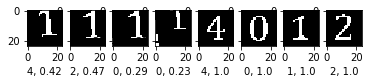

In [203]:
label = ['0', '1', '2', '4']
test = load_image("./test", nh, nw)
n = len(test)

print('shape', test.shape)

#f, axarr = plt.subplots(1, 4)

# 显示第一张图片
for i in range(n):
    plt.subplot(1, n, i + 1)

    pic=test[i,:,:,:]
    #plt.imshow(pic)

    dat = rgb2bw(pic, gc)
    dat = preprocess(dat)
    #dat = preprocess(dat, nh, nw)
    k, sim = match(master, dat)
    
    plt.imshow(dat, cmap='gray')
    plt.xlabel(label[k] + ', ' + str(float('%.2f' %  sim)))
    
plt.show()

In [72]:
#print(samples[0,400:500,500:600,:])
print(test[0,:1,:,:])

[[[0.54901961 0.50196078 0.51764706]
  [0.61960784 0.57254902 0.58823529]
  [0.70196078 0.65882353 0.6745098 ]
  ...
  [0.73333333 0.74901961 0.74509804]
  [0.73333333 0.74901961 0.74509804]
  [0.7372549  0.75294118 0.74901961]]]


## model output##

In [204]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    :param session: 需要转换的tensorflow的session
    :param keep_var_names:需要保留的variable，默认全部转换constant
    :param output_names:output的名字
    :param clear_devices:是否移除设备指令以获得更好的可移植性
    :return:
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        # 如果指定了output名字，则复制一个新的Tensor，并且以指定的名字命名
        if len(output_names) > 0:
            for i in range(output_names):
                # 当前graph中复制一个新的Tensor，指定名字
                tf.identity(model.model.outputs[i], name=output_names[i])
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph